# Exploratory Data Analysis of Pro-Level League of Legends Matches

The data being used is obtained from [Oracle's Elixer]. A [codebook] for the variables is also included.

[Oracle's Elixer]: http://oracleselixir.com/match-data/
[codebook]: http://oracleselixir.com/match-data/match-data-dictionary/

First I will import all neccessary packages in a separate cell.

In [55]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb
from scipy import stats

Then I will download a series of xlsx links, read them into a pandas dataframe and concatenate them together.

In [32]:
# List of excel file url's to read
root_url = "http://oracleselixir.com/gamedata/"
urls = ["2016-spring/", "msi-2016/", "2016-regionals-and-worlds/", "2016-summer/", "2017-spring/", "2017-msi/", "2017-summer/"]
urls = [root_url + url for url in urls]

# There was a formatting change in how the excel files were posted.
# Originally they had a readme sheet and a data sheet, later there is only 1 sheet in the wb containing all data.
partial_dfs = [pd.read_excel(url, 'data') if i < 3 else pd.read_excel(url, 'Sheet1') for i, url in enumerate(urls)]

# Join individual file df's together
df = pd.concat(partial_dfs, ignore_index = True)

Next, I'll take a quick look at the dataset.

In [64]:
print(df.head(10))

print(df.tail(10))

print(df.columns)

print(df.info())

    a  airdrakes     ban1       ban2        ban3 ban4 ban5   champion  \
0   3        NaN  Kindred   Kassadin  Tahm Kench  NaN  NaN       Olaf   
1  13        NaN  Kindred   Kassadin  Tahm Kench  NaN  NaN        Zac   
2  10        NaN  Kindred   Kassadin  Tahm Kench  NaN  NaN    LeBlanc   
3   9        NaN  Kindred   Kassadin  Tahm Kench  NaN  NaN     Lucian   
4  10        NaN  Kindred   Kassadin  Tahm Kench  NaN  NaN      Poppy   
5   4        NaN     Lulu  Gangplank        Ryze  NaN  NaN  Lissandra   
6   5        NaN     Lulu  Gangplank        Ryze  NaN  NaN    Lee Sin   
7   5        NaN     Lulu  Gangplank        Ryze  NaN  NaN    Orianna   
8   3        NaN     Lulu  Gangplank        Ryze  NaN  NaN     Ezreal   
9   5        NaN     Lulu  Gangplank        Ryze  NaN  NaN    Trundle   

       ckpm  csat10   ...    visionwards  wardkills  wards  wardshare  \
0  0.834492    76.0   ...              2       12.0   18.0   0.155172   
1  0.834492    43.0   ...              6       15.

Next, I split the dataset into two separate data frames for team data and individual player data.

In [50]:
teamDF = df[df['player'] == 'Team']
playerDF = df[df['player'] != 'Team']

Next I'll make a heatmap of the correlation matrix for `teamDF`. It appears there are a lot of strongly correlated variables, but it's difficult to see which they are due to the large number of variables. 

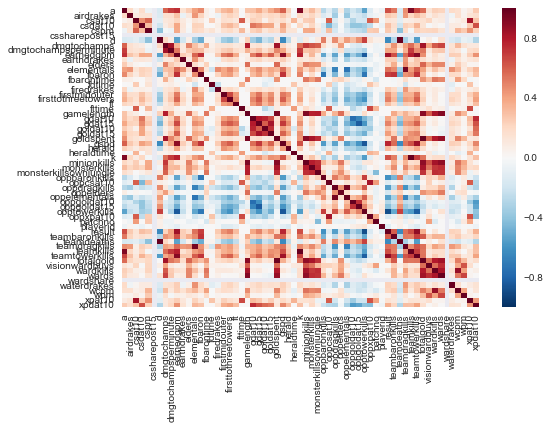

In [67]:
corr = teamDF.corr()
sb.heatmap(corr, 
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values)
plt.show()

Let's try to examine the correlation between the 'result' column (since that will ideally be the outcome variable for future analysis) and the other columns.

In [80]:
print(teamDF.corrwith(teamDF[['result']]))

a                        NaN
airdrakes                NaN
csat10                   NaN
csdat10                  NaN
cspm                     NaN
cssharepost15            NaN
d                        NaN
dmgtochamps              NaN
dmgtochampsperminute     NaN
earnedgpm                NaN
earthdrakes              NaN
elders                   NaN
elementals               NaN
fbaron                   NaN
fbarontime               NaN
fdtime                   NaN
firedrakes               NaN
firstmidouter            NaN
firsttothreetowers       NaN
ft                       NaN
fttime                   NaN
gamelength               NaN
gdat10                   NaN
gdat15                   NaN
goldat10                 NaN
goldat15                 NaN
goldspent                NaN
gspd                     NaN
herald                   NaN
heraldtime               NaN
                        ... 
minionkills              NaN
monsterkills             NaN
monsterkillsownjungle    NaN
oppbaronkills 

Unfortunately, (I think) because the 'result' column contains binary categorical data, the default pearson correlation method doesn't work here.

Instead, I'll try to look at correlation through Point-Biserial Correlation Coefficient.

In [134]:
# After lots of headbanging, I realized that Point-Biserial won't work for comparing
# dichotomous data with an array of object type. For now I've just dropped all columns
# of that type from the correlation analysis. But I'll revisit this later, as there are
# definitely important, potential predictors being dropped.

nonObjCols = teamDF.columns[teamDF.dtypes != object]

corrResult = [stats.pointbiserialr(teamDF[['result']][pd.notnull(teamDF[col])], teamDF[[col]][pd.notnull(teamDF[col])])[0] for col in nonObjCols]

[print(nonObjCols[i], ":", x[0]) for i, x in enumerate(corrResult)]

a : 0.641352309426
airdrakes : 0.260306068491
csat10 : 0.134268277119
csdat10 : 0.29884262324
cspm : 0.262894977475
cssharepost15 : nan
d : -0.640422453739
dmgtochamps : 0.225753447553
dmgtochampsperminute : 0.391600105028
earnedgpm : 0.851190734698
earthdrakes : 0.24404335163
elders : 0.173901260739
elementals : 0.545415298723
fbaron : 0.689391945249
fbarontime : 0.0
fdtime : 0.0
firedrakes : 0.258533921177
firstmidouter : 0.450894805762
firsttothreetowers : 0.511044176707
ft : 0.304718875502
fttime : 0.0
gamelength : 0.0
gdat10 : 0.386251292234
gdat15 : 0.499905176821
goldat10 : 0.29309207602
goldat15 : 0.415880707201
goldspent : 0.205437616534
gspd : 0.764676248384
herald : 0.313396149119
heraldtime : 0.0
k : 0.641453700529
minionkills : 0.0460630953704
monsterkills : 0.234337293734
monsterkillsownjungle : 0.0146188081146
oppbaronkills : -0.60365075934
oppcsat10 : -0.134268277119
oppdragkills : -0.550282863691
oppelders : -0.173901260739
oppelementals : -0.545415298723
oppgoldat10 :

C:\Users\glander\Anaconda3\lib\site-packages\scipy\stats\stats.py:3016: RuntimeWarning: Mean of empty slice.
  mx = x.mean()
C:\Users\glander\Anaconda3\lib\site-packages\numpy\core\_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
C:\Users\glander\Anaconda3\lib\site-packages\scipy\stats\stats.py:3017: RuntimeWarning: Mean of empty slice.
  my = y.mean()
C:\Users\glander\Anaconda3\lib\site-packages\scipy\stats\stats.py:3021: RuntimeWarning: invalid value encountered in true_divide
  r = r_num / r_den
C:\Users\glander\Anaconda3\lib\site-packages\scipy\stats\stats.py:3025: RuntimeWarning: invalid value encountered in greater
  r = max(min(r, 1.0), -1.0)
C:\Users\glander\Anaconda3\lib\site-packages\scipy\stats\stats.py:3025: RuntimeWarning: invalid value encountered in less
  r = max(min(r, 1.0), -1.0)
C:\Users\glander\Anaconda3\lib\site-packages\scipy\stats\stats.py:5277: RuntimeWarning: invalid value encountered in less
  x =

[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None]

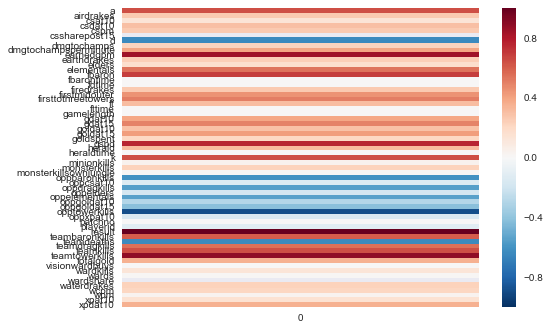

In [142]:
sb.heatmap(corrResult, 
            yticklabels=nonObjCols.values)
plt.show()

This is slightly better, but still not especially readable/useful.

Let's try to look at the most strongly correlated.

In [157]:
namedCorrResult = [[nonObjCols[i], corr[0]] for i, corr in enumerate(corrResult)]
namedCorrResult = sorted(namedCorrResult, key=lambda x: x[1])

topCorr = namedCorrResult[:10] + namedCorrResult[-10:]

[print(tc) for tc in topCorr]

['opptowerkills', -0.88504221744106315]
['d', -0.64042245373863016]
['teamdeaths', -0.64042245373863016]
['oppbaronkills', -0.60365075933978551]
['oppdragkills', -0.55028286369124468]
['oppelementals', -0.54541529872342631]
['oppgoldat15', -0.41588070720115933]
['oppgoldat10', -0.29309207602004705]
['oppelders', -0.17390126073864759]
['oppxpat10', -0.15096215479228858]
['teamdragkills', 0.54998850298283108]
['teambaronkills', 0.60365075933978551]
['k', 0.64145370052869677]
['teamkills', 0.64145370052869677]
['fbaron', 0.68939194524874969]
['gspd', 0.76467624838407822]
['earnedgpm', 0.85119073469764084]
['teamtowerkills', 0.88504221744106315]
['result', 1.0]
['wardshare', nan]


[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None]

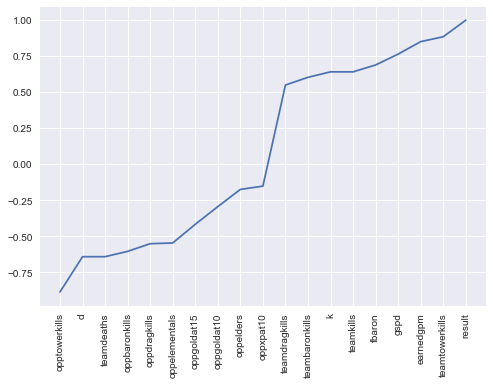

In [172]:
topCorrTrans = list(map(list, zip(*topCorr[:-1])))

sb.set_style("darkgrid")
plt.plot(topCorrTrans[1])
plt.xticks(range(len(topCorrTrans[0])), topCorrTrans[0], rotation='vertical')
plt.show()

In [35]:
df.to_excel('Merged-LoL-Data.xlsx')